In [12]:
#!/usr/bin/python2.7
import sys
sys.path.append('../')
from Linearity import Neuron
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
plt.style.use('neuron')
import lmfit

In [2]:
n = Neuron.load('/media/sahil/NCBS_Shares_BGStim/patch_data/161220/c2_EI/plots/c2_EI.pkl')

In [3]:
# def delay_excitation(x, a=1, b=1, c=1):
#     # Delay as a function of excitation
#     return a + b*np.exp(-c*x)
def delay_excitation(x, a=1, b=1):
    # Delay as a function of excitation
    return a + (b/x)

In [4]:
def findOnsetTime(trial, step=.25, slide = 0.05, minOnset = 2., maxOnset = 50., initpValTolerance=1.0, pValMinTolerance = 0.05):
    maxIndex = int(trial.F_sample*maxOnset*1e-3)
    if expType == 1:
        maxOnsetIndex = np.argmax(-trial.interestWindow[:maxIndex])
    elif expType == 2:
        maxOnsetIndex = np.argmax(trial.interestWindow[:maxIndex])
    else:
        maxOnsetIndex = np.argmax(trial.interestWindow[:maxIndex])
    
    window_size = len(trial.interestWindow)
    step_size = int(trial.F_sample*step*1e-3)
    
    overlap =  int(trial.F_sample*slide*1e-3)
    
    index_right = maxOnsetIndex
    index_left = index_right - step_size
    minOnsetIndex = int(trial.F_sample*minOnset*1e-3)
    
    baseMean = np.mean(trial.interestWindow[:minOnsetIndex])
    factor = 5
    thresholdGradient = 0.01
    pValTolerance = initpValTolerance
    
    #if -baseMean*factor < trial.interestWindow[maxOnsetIndex] < baseMean*factor:
    #    return 0
    #print baseMean
    l_window = trial.interestWindow[:minOnsetIndex]
    while (index_left>minOnset):
        r_window = trial.interestWindow[index_left:index_right] #, trial.baselineWindow #trial.interestWindow[index_left - step_size:index_left]
    
        #if baseMean - 0.1 < np.mean(r_window) < baseMean + 0.1:
        #if (-factor*baseMean  < np.mean(r_window) < factor*baseMean) and (np.average(np.abs(np.gradient(r_window))) < thresholdGradient):
        
        stat, pVal = ss.ks_2samp(r_window, l_window)
        if pVal>pValTolerance:
            return float(index_right)/trial.F_sample

        else:
            index_left-=overlap
            index_right-=overlap
            if index_left<=minOnsetIndex:
                pValTolerance/=2
                #factor*=2
                #thresholdGradient*=2
                if pValTolerance<pValMinTolerance:
#                         print ("{} pval too low for {} tolerance, increasing baseline size".format(pVal, pValTolerance))
#                         minOnset*=2
#                         #step_size*=2
#                         index_right = maxOnsetIndex
#                         index_left = maxOnsetIndex - step_size

#                         l_window = trial.interestWindow[:minOnsetIndex]
#                         pValTolerance = initpValTolerance 

#                         if minOnsetIndex > maxOnsetIndex - step_size :
                            print ("Returning Nan")
                            return np.nan
                else:
                    index_right = maxOnsetIndex
                    index_left = maxOnsetIndex - step_size

In [5]:
avg_exc_onset = {}
avg_inh_onset = {}
avg_exc_max = {}
exc_onsets, inh_onsets = {}, {}
exc_max,inh_max = {}, {}
err_inh_onsets = {}
for expType, exp in n:
    for sqr in exp:
        for coord in exp[sqr].coordwise:
            if expType == 1:
                for trial in exp[sqr].coordwise[coord].trials:
                    exc_onsets[(sqr,trial.index)] = findOnsetTime(trial)*1e3
                    exc_max[(sqr,trial.index)] = -trial.feature[5]*1e6
                    #exp[sqr].coordwise[coord].average_feature[5]
            if expType == 2:
                list_inh_onset = []
                for trial in exp[sqr].coordwise[coord].trials:
                    inh_onsets[(sqr,trial.index)] = findOnsetTime(trial)*1e3
                    list_inh_onset.append(inh_onsets[(sqr,trial.index)])
                    inh_max[(sqr,trial.index)] = trial.feature[0]*1e6
                avg_onset = np.nanmean([onset for onset in list_inh_onset if onset])
                err_onset = np.nanstd([onset for onset in list_inh_onset if onset])
                for trial in exp[sqr].coordwise[coord].trials:
                    avg_inh_onset[(sqr,trial.index)] = avg_onset
                    err_inh_onsets[(sqr,trial.index)] = err_onset
#print (avg_exc_max, avg_exc_onset, avg_inh_onset)

Returning Nan
Returning Nan
Returning Nan
Returning Nan


In [6]:
delay, max_current = [], []
del_err, max_err= [], []
inhibOnset = []
for key in set(exc_onsets).intersection(set(avg_inh_onset)):
    if avg_inh_onset[key] and exc_onsets[key]:
        if not np.isnan(avg_inh_onset[key]) and not np.isnan (exc_onsets[key]) and not np.isnan (exc_max[key]):
            delay.append(avg_inh_onset[key]- exc_onsets[key])
            max_current.append(exc_max[key])
            del_err.append(err_inh_onsets[key])
            inhibOnset.append(inh_onsets[key])
#         del_err.append()
#         max_err.append()

In [7]:
delay_Model = lmfit.Model(delay_excitation)
delay_pars = delay_Model.make_params()

delay = np.array(delay)
max_current = np.array(max_current)

delay_result = delay_Model.fit(delay, delay_pars, x=max_current)
print (delay_result.params)
print (delay_result.aic)
print (delay_result.redchi)

Parameters([('a', <Parameter 'a', value=1.2930871332046887 +/- 0.296, bounds=[-inf:inf]>), ('b', <Parameter 'b', value=0.33247257039723471 +/- 0.0264, bounds=[-inf:inf]>)])
233.909971493
4.7924962113


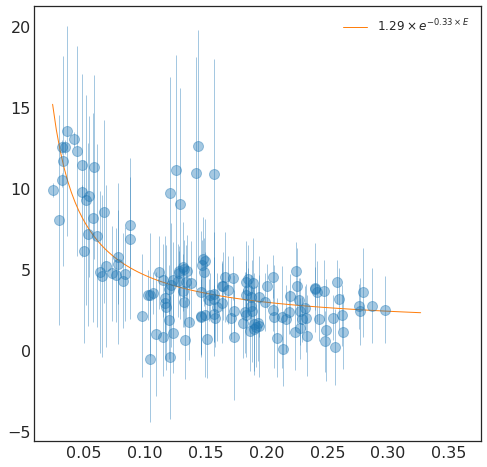

In [14]:
fig, ax = plt.subplots()
ax.errorbar(np.array(max_current), np.array(delay), fmt ='o', yerr=np.array(del_err), alpha=0.4)
#ax.scatter(np.array(max_current)*1e6, np.array(delay)*1e3)
current_linspace= np.linspace(np.min(max_current),1.1*np.max(max_current),100)
ax.plot(current_linspace, delay_result.eval(x=current_linspace), '-', label="${:.2f} \\times e^{{-{:.2f} \\times E }}$".format(delay_result.params['a'].value, delay_result.params['b'].value))

# ax.plot(1./(delay_result.params['c'].value), delay_result.eval(x=1./(delay_result.params['c'].value)), 'ko')
xmin, xmax = ax.get_xlim()
# ax.hlines(y=0, xmin=xmin, xmax=xmax, linestyles='--', alpha=0.5)
# ax.hlines(y=delay_result.params['a'].value, xmin=xmin, xmax=xmax, linestyles='--', alpha=0.5)
# ax.set_xlabel("$I_{max}^{exc}$")
# ax.set_ylabel("Delay $(\\delta_{inh})$")

# ax.annotate("",
#             xy=(xmax, 0.), xycoords='data',
#             xytext=(xmax, delay_result.params['a'].value), textcoords='data',
#             arrowprops=dict(arrowstyle="<->",
#                             connectionstyle="arc3"),
#             )
# ax.text(1.01*xmax, 1., "$\\delta_{min}$")

# ax.annotate("",
#             xy=(0, 0), xycoords='data',
#             xytext=(0, delay_result.params['b'].value + delay_result.params['a'].value), textcoords='data',
#             arrowprops=dict(arrowstyle="<->",
#                             connectionstyle="arc3"),
#             )
# ax.text(xmin*1.5, 10., "$\\delta_{max}$")

# ax.annotate("",
#             xy=(xmax, delay_result.params['a'].value), xycoords='data',
#             xytext=(xmax,  delay_result.params['b'].value + delay_result.params['a'].value), textcoords='data',
#             arrowprops=dict(arrowstyle="<->",
#                             connectionstyle="arc3"),
#             )
# ax.text(1.01*xmax, 10., "$m$")

# ax.text(0.006, 6., "$k$")
ax.set_xlim(xmax= xmax*1.1)
plt.legend(fontsize=12)
fig.set_figwidth(8)
fig.set_figheight(8)
plt.show()

In [9]:
fig, ax = plt.subplots()
ax.errorbar(np.array(max_current), np.array(delay), fmt ='o', yerr=np.array(del_err), alpha=0.4)
#ax.scatter(np.array(max_current)*1e6, np.array(delay)*1e3)
current_linspace= np.linspace(0,1.1*np.max(max_current))
ax.plot(current_linspace, delay_result.eval(x=current_linspace), '-', label="${:.2f} + {:.2f} \\times e^{{-{:.2f} \\times E }}$".format(delay_result.params['a'].value, delay_result.params['b'].value, delay_result.params['c'].value))

ax.plot(1./(delay_result.params['c'].value), delay_result.eval(x=1./(delay_result.params['c'].value)), 'ko')
xmin, xmax = ax.get_xlim()
ax.hlines(y=0, xmin=xmin, xmax=xmax, linestyles='--', alpha=0.5)
ax.hlines(y=delay_result.params['a'].value, xmin=xmin, xmax=xmax, linestyles='--', alpha=0.5)
ax.set_xlabel("$I_{max}^{exc}$")
ax.set_ylabel("Delay $(\\delta_{inh})$")

ax.annotate("",
            xy=(xmax, 0.), xycoords='data',
            xytext=(xmax, delay_result.params['a'].value), textcoords='data',
            arrowprops=dict(arrowstyle="<->",
                            connectionstyle="arc3"),
            )
ax.text(1.01*xmax, 1., "$\\delta_{min}$")

ax.annotate("",
            xy=(0, 0), xycoords='data',
            xytext=(0, delay_result.params['b'].value + delay_result.params['a'].value), textcoords='data',
            arrowprops=dict(arrowstyle="<->",
                            connectionstyle="arc3"),
            )
ax.text(xmin*1.5, 10., "$\\delta_{max}$")

ax.annotate("",
            xy=(xmax, delay_result.params['a'].value), xycoords='data',
            xytext=(xmax,  delay_result.params['b'].value + delay_result.params['a'].value), textcoords='data',
            arrowprops=dict(arrowstyle="<->",
                            connectionstyle="arc3"),
            )
ax.text(1.01*xmax, 10., "$m$")

ax.text(0.006, 6., "$k$")
ax.set_xlim(xmax= xmax*1.1)
plt.legend(fontsize=12)
fig.set_figwidth(8)
fig.set_figheight(8)
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in divide
  


KeyError: 'c'

## Individual scatters

In [ ]:
inhibOnset,inhibMax = [], []
excMax, excOnset = [], []
for key in inh_onsets:
        inhibOnset.append(inh_onsets[key])
        inhibMax.append(inh_max[key])
for key in exc_onsets:
        excOnset.append(exc_onsets[key])
        excMax.append(exc_max[key])
#         del_err.append()
#         max_err.append()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(np.array(excMax)*1e6, np.array(inhibOnset)*1e3, label="inh")
ax.scatter(np.array(excMax)*1e6, np.array(excOnset)*1e3, label="exc")
# ax.set_ylim(-1,20)
# ax.set_xlim(0,0.175)
plt.legend()
fig.set_figwidth(8)
fig.set_figheight(8)
plt.show()

## Paired scatter

In [ ]:
inhibOnset,inhibMax = [], []
excMax, excOnset = [], []
for key in set(inh_onsets).intersection(exc_onsets):
        inhibOnset.append(inh_onsets[key])
        excOnset.append(exc_onsets[key])

In [ ]:
fig, ax = plt.subplots()
ax.scatter(np.array(excOnset)*1e3, np.array(inhibOnset)*1e3)
ax.set_ylim(0,30)
ax.set_xlim(0,30)
fig.set_figwidth(8)
fig.set_figheight(8)
plt.show()